In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib/")
sys.path.append("C:/dev/pycmqlib/scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
%matplotlib inline

In [3]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu'] #, 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd']#, 'AP', 'sp']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [4]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2015,10,1)
end_date = datetime.date(2020,3,25)

product_list = ['cu', 'al', 'zn', 'pb', 'ni', 'sn'] #['rb', 'hc', 'i', 'j'] #['cu', 'al', 'zn', 'pb'] #
need_shift = 1
freq = 'm'

args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift}
bond_args = {'n': 1, 'roll_rule': '-20b', 'freq': freq, 'need_shift': need_shift}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift}

df_list = []
for idx, asset in enumerate(product_list):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb']:
        use_args = base_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(backtest.sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print "loading mkt = %s, args = %s" % (asset, use_args)
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    xdf = df[field_list]
    xdf.columns = [(asset, col) for col in xdf.columns]
    df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).fillna(method = 'ffill').dropna()

loading mkt = cu, args = {'need_shift': 1, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'm', 'start_date': datetime.date(2015, 10, 1), 'roll_rule': '-35b'}
loading mkt = al, args = {'need_shift': 1, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'm', 'start_date': datetime.date(2015, 10, 1), 'roll_rule': '-35b'}
loading mkt = zn, args = {'need_shift': 1, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'm', 'start_date': datetime.date(2015, 10, 1), 'roll_rule': '-35b'}
loading mkt = pb, args = {'need_shift': 1, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'm', 'start_date': datetime.date(2015, 10, 1), 'roll_rule': '-35b'}
loading mkt = ni, args = {'need_shift': 1, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'm', 'start_date': datetime.date(2015, 10, 1), 'roll_rule': '-35b'}
loading mkt = sn, args = {'need_shift': 1, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'm', 'start_date': datetime.date(2015, 10, 1), 'roll_rule': '-35b'

In [107]:
xdf = dh.conv_ohlc_freq1(df, 'm')
#xdf = df.copy()
#xdf = dh.day_split1(xdf, [300, 352, 450, 1500, 1528, 1630, 1655, 1724, 1930, 1949, 2018, 2047, 2100])

#xdf = dh.day_split1(xdf, [300, 1500, 2115])
xdf['start_min'] = xdf.index.to_series().apply(lambda x: misc.get_min_id(x))
sr_win = 20
std_win = 50
for asset in product_list:
    if need_shift == 1:
        xdf[(asset, 'lr')] = ((xdf[(asset, 'close')]- xdf[(asset, 'shift')]).astype('float')\
                                /(xdf[(asset, 'close')].shift(1) - xdf[(asset, 'shift')]) - 1.0) 
    else:
        xdf[(asset, 'lr')] = (xdf[(asset, 'close')].astype('float')\
                              / xdf[(asset, 'close')].shift(1) - 1.0)
    xdf[(asset, 'lr_sr')] = xdf[(asset, 'lr')].rolling(sr_win).mean()
    xdf[(asset, 'std_sr')] = xdf[(asset, 'lr')].rolling(sr_win).std()
    xdf[(asset, 'sr')] = xdf[(asset, 'lr_sr')]/xdf[(asset, 'std_sr')]
    xdf[(asset, 'std')] = xdf[(asset, 'lr')].rolling(std_win).std()
adf_dict = xdf[[(asset, 'sr') for asset in product_list]]
sum_rank = adf_dict.rank(axis=1, method='first')
sum_rank.columns = product_list
rng_dict = adf_dict.max(axis=1) - adf_dict.min(axis=1)
#xdf[[(asset, 'lr') for asset in product_list]].plot()

                     rebal_seqno  start_min  rebal_flag
datetime                                               
2020-03-24 13:30:00        12734       1930           1
2020-03-24 13:57:00        12735       1957           1
2020-03-24 14:54:00        12736       2054           1
2020-03-25 09:00:00        12737       1500           1
2020-03-25 09:12:00        12738       1512           1
2020-03-25 10:09:00        12739       1609           1
2020-03-25 11:06:00        12740       1706           1
2020-03-25 13:30:00        12741       1930           1
2020-03-25 13:57:00        12742       1957           1
2020-03-25 14:54:00        12743       2054           1
date
2020-02-13    3.942938e+11
2020-02-14    3.981587e+11
2020-02-17    4.004594e+11
2020-02-18    3.963350e+11
2020-02-19    3.991862e+11
2020-02-20    3.980047e+11
2020-02-21    4.057060e+11
2020-02-24    4.080304e+11
2020-02-25    4.092681e+11
2020-02-26    4.083553e+11
2020-02-27    4.065452e+11
2020-02-28    4.100046e+11

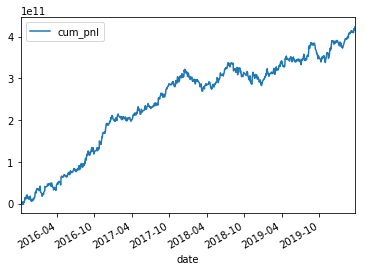

                               0
avg_pnl_1y          3.789383e+08
avg_pnl_2y          2.935414e+08
avg_pnl_3y          3.055478e+08
avg_pnl_4y          3.995339e+08
max_dd_period_1y   -7.000000e+01
max_dd_period_2y   -1.610000e+02
max_dd_period_3y   -1.610000e+02
max_dd_period_4y   -1.610000e+02
max_drawdown_1y    -4.752015e+10
max_drawdown_2y    -5.470052e+10
max_drawdown_3y    -5.470052e+10
max_drawdown_4y    -5.470052e+10
num_days_1y         2.450000e+02
num_days_2y         4.870000e+02
num_days_3y         7.310000e+02
num_days_4y         9.750000e+02
profit_dd_ratio_1y  1.953695e+00
profit_dd_ratio_2y  2.613406e+00
profit_dd_ratio_3y  4.083242e+00
profit_dd_ratio_4y  7.121423e+00
sharp_ratio_1y      1.535787e+00
sharp_ratio_2y      1.211720e+00
sharp_ratio_3y      1.309281e+00
sharp_ratio_4y      1.720901e+00
std_pnl_1y          3.916858e+09
std_pnl_2y          3.845627e+09
std_pnl_3y          3.704645e+09
std_pnl_4y          3.685514e+09
tot_cost_1y         3.217860e+10
tot_cost_2

In [109]:
total_risk = 1000000000.0
rebal_freq = 4
margin_rate = [0.08, 0.08]
pnl_tenors = ['1y', '2y', '3y', '4y']
cost_ratio = 1.0
#offset_list = [0.0, 0.0, 0.0, 0.0, 0.0]
offset_list = [10.0, 5.0, 5.0, 5.0, 10.0, 10.0]
offset_list = [x * 0.25 for x in offset_list]
start_capital = 0.0

quantile_cutoff = 0.20
kcut = int(quantile_cutoff * len(product_list) + 0.5)
upper_rank = len(product_list) - kcut
lower_rank = 1 + kcut
xdf['rebal_flag'] = 1
#print rng_dict['lr0'][-10:]
#flag = (xdf['start_min'].isin([])) | (rng_dict['lr0'] < 0.0)
#xdf.loc[flag, 'rebal_flag'] = 0

xdf['rebal_seqno'] = xdf['rebal_flag'].cumsum()
print xdf[['rebal_seqno', 'start_min', 'rebal_flag']][-10:]

long_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)
short_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)

for rebal_idx in range(rebal_freq):
    long_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
    short_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
    rebal_flag = xdf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx) & (xdf['rebal_flag'] == 1)
    for asset in product_list:
        long_tmp.loc[(sum_rank[asset] > upper_rank) & rebal_flag, asset] = 1.0
        long_tmp.loc[(sum_rank[asset] <= upper_rank) & rebal_flag, asset] = 0.0
        short_tmp.loc[(sum_rank[asset] < lower_rank) & rebal_flag, asset] = 1.0
        short_tmp.loc[(sum_rank[asset] >= lower_rank) & rebal_flag, asset] = 0.0
    long_tmp = long_tmp.fillna(method='ffill').fillna(0)
    short_tmp = short_tmp.fillna(method='ffill').fillna(0)
    #long_sum = long_tmp.sum(axis=1)
    #short_sum = short_tmp.sum(axis=1)
    long_pos = long_pos + long_tmp #.div(long_sum,axis=0)
    short_pos = short_pos + short_tmp #.div(short_sum,axis=0)

net_pos = long_pos - short_pos

pos_nchg = (net_pos == net_pos.shift(1))
net_pos[pos_nchg] = np.nan

extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
df_list = []

for asset, offset in zip(product_list, offset_list):
    if need_shift == 1:
        orig_close = xdf[(asset, 'close')] - xdf[(asset, 'shift')]
    elif need_shift == 2:
        orig_close = xdf[(asset, 'close')] * np.exp(-xdf[(asset, 'shift')])
    else:
        orig_close = xdf[(asset, 'close')]
    xdf[(asset, 'pos')] = (net_pos[asset] * total_risk / rebal_freq/ xdf[(asset, 'std')] /orig_close).astype('float').shift(1).fillna(method='ffill').fillna(0.0).astype('int')
    xdf[(asset, 'traded_price')] = xdf[(asset, 'open')]
    xdf.ix[-1, (asset, 'pos')] = 0
    xdf[(asset, 'cost')] = abs(xdf[(asset, 'pos')] - xdf[(asset, 'pos')].shift(1)) * offset
    xdf[(asset, 'cost')] = xdf[(asset, 'cost')].fillna(0.0)
    fields = [(asset, field) for field in extract_fields]    
    tdf = xdf[fields]
    tdf.columns = extract_fields
    tdf['date'] = xdf['date']
    tdf['min_id'] = xdf['min_id']
    df_list.append(tdf)
    #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)    
    #tdf.to_csv("test_%s_offset_%s.csv" % (asset, offset))
#xdf.to_csv("test_result.csv")
(res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, 'm', tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
#print net_pos
print ts['cum_pnl'][-30:]
ts[['cum_pnl']].plot()
plt.show()
pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
print pnl_df